# [George McNinch](http://gmcninch.math.tufts.edu) Math 87 - Spring 2024

# Week 3

# § Network flows and linear programming 02

# Grocery example

A fruit wholesaler buys and sells apples according to the following
prices and demand:

| Month                |  Aug |  Sep |  Oct |  Nov |  Dec |  Jan |  Feb |  Mar |  Apr |  May |  Jun |  Jul |
|:---------|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
| price/kg from grower | 0.80 | 0.55 | 0.55 | 0.65 | 0.75 | 0.85 | 0.95 |   \- |   \- |   \- |   \- |   \- |
| sale price/kg        | 0.90 | 0.65 | 0.65 | 0.85 | 1.00 | 1.00 | 1.20 | 1.20 | 1.20 | 1.00 | 0.80 | 0.80 |
| demand in 1000kg     |   10 |   15 |   15 |   15 |   13 |   10 |   10 |   10 |    9 |    7 |    5 |    5 |

The wholesaler can store 50,000kg at a cost of \$0.025 per kg per month.
Unlimited supplies are available from September to January but only
15,000kg are available in August and February and none during the rest
of the year.

We consider the profit for a year (12 months), from August to the next
July. We suppose that there are *no* apples to carry over from the
previous month – we begin with no apples.

Our goal: Maximize the profit!


We’ll begin by formulating the flow model.

Remember that each edge in the graph corresponds to a variable in our
linear program. We are going to label each edge with a symbol
$[c,u,\ell]$ representing the “cost” (i.e. the contribution of that
variable to the objective function), an upper bound $u$ for that
variable, and a lower bound $\ell$ for that variable.

We are going to construct the diagram using `graphviz`, though the main
point here is the diagram itself rather than the code used to produce
it. (I’m including the code so you can copy it if you wish).

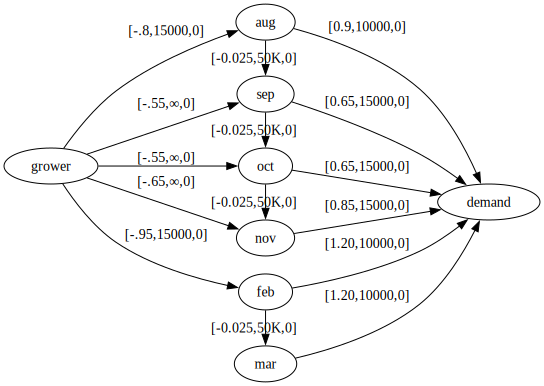

In [5]:
from graphviz import Digraph

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

dot = Digraph('fruit wholesaler model')

dot.attr(rankdir='LR')
dot.node('g','grower')

with dot.subgraph(name='months') as c:
    c.attr(rank='same')
    c.node('aug')
    c.node('sep')
    c.node('oct')
    c.node('nov')
    c.node('feb')
    c.node('mar')

    
dot.node('d','demand')

dot.edge('g','aug',label='[-.8,15000,0]')
dot.edge('g','sep',label='[-.55,∞,0]')
dot.edge('g','oct',label='[-.55,∞,0]')
dot.edge('g','nov',label='[-.65,∞,0]')
dot.edge('g','feb',label='[-.95,15000,0]')

dot.edge('aug','sep',label='[-0.025,50K,0]')
dot.edge('sep','oct',label='[-0.025,50K,0]')
dot.edge('oct','nov',label='[-0.025,50K,0]')
dot.edge('feb','mar',label='[-0.025,50K,0]')


dot.edge('aug','d',label='[0.9,10000,0]')
dot.edge('sep','d',label='[0.65,15000,0]')
dot.edge('oct','d',label='[0.65,15000,0]')
dot.edge('nov','d',label='[0.85,15000,0]')
dot.edge('feb','d',label='[1.20,10000,0]')
dot.edge('mar','d',label='[1.20,10000,0]')

    
dot

#dot.format='png'
#dot.render()

Now let’s formulate the linear program.

Let’s number our months in a slightly odd way. Our year starts in
`august`, so we number as follows:

| `aug` | `sep` | `oct` | `nov` | `dec` | `jan` | `feb` | `mar` | `apr` | `may` | `jun` | `jul` |
|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|     1 |     2 |     3 |     4 |     5 |     6 |     7 |     8 |     9 |    10 |    11 |    12 |

We need to name our variables; we’ll use the above numbering:

-   $g_i$ = \# kg bought in month $i$, for $1 \le i \le 12$.
-   $s_i$ = \# kg stored from month $i$ to month $i+1$
-   $d_i$ = \# kg sold in month $i$

All of our variables are assumed to be non-negative:
$g_i \ge 0, s_i \ge 0, d_i \ge 0$ for all $i$.

We’ve been told the following:

> Unlimited supplies are available (from the grower) from September to
> January but only 15,000kg are available in August and February and
> none during the rest of the year.

This gives us some “upper bound” inequalities:

$$\begin{bmatrix}
    g_1 \\ g_2 \\ g_3 \\ g_4 \\ g_5 \\ g_6 \\ 
    \end{bmatrix}
    \le 
    \begin{bmatrix}
       1500 \\   
       \infty \\ 
       \infty \\ 
       \infty \\ 
       \infty \\
       \infty
    \end{bmatrix}
    \quad \text{and} \quad
    \begin{bmatrix}
    g_7 \\ g_8 \\ g_9 \\ g_{10} \\ g_{11} \\ g_{12}
    \end{bmatrix}
    \le 
    \begin{bmatrix}
    15000 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0
    \end{bmatrix}$$

(since $g_i \ge 0$ is non-negative, the above conditions for
$8 \le i \le 12$ *amount to* an equality condition of $g_i = 0$ for
these $i$, but we’ll enter it as an inequality condition for
uniformity).

We’ve also been told:

> The wholesaler can store 50,000kg at a cost of \$0.025 per kg per
> month.

This yields the upper bound - $s_i \le 50000$ for $1 \le i \le 12$

Now, we know from table the demand for each month. Remember what we are
doing: with the linear program, we are trying to decide the optimal
values of our decision variables – i.e. how many apples do we buy each
month? and how many apples do we store each month? According to the
model, the number of apples we expect to *sell* depends on these choices
(via the conservation laws). So to be sensible, our model must view the
anticipated demand (listed in the table) as an **upper bound** for the
amount we can sell. More precisely, we should impose the constraint that
the number $d_i$ of `kg` of apples delivered to customers is $\le$ the
anticipated demand for each month. (Of course, this is what the label on
the diagram indicates! Here I’m trying to explain why we have chosen
that labeling).

This amount to the condition: $$\begin{bmatrix}
    d_1 \\ d_2 \\ d_3 \\ d_4 \\ d_5 \\ d_6 \\ 
    \end{bmatrix}
    \le 
    \begin{bmatrix}
       10 \\   
       15 \\ 
       15 \\ 
       15 \\ 
       13 \\
       10    \end{bmatrix}
    \quad \text{and} \quad
    \begin{bmatrix}
    d_7 \\ d_8 \\ d_9 \\ d_{10} \\ d_{11} \\ d_{12}
    \end{bmatrix}
    \le 
    \begin{bmatrix}
    10 \\
    10 \\
    9 \\
    7  \\
    5 \\
    5
    \end{bmatrix}$$

Conservation:

The internal nodes of our network flow diagram correspond to months. The
arrow “going in” to the node amount to available apples, and they
correspond to purchases ($g_i$) and storage ($s_{i-1}$ unless $i=1$).
The arrows going out correspond to storage ($s_i$) and to apples
delivered to customers ($d_i$). Thus, we must have

-   $s_1 + d_1 - g_1 = 0$
-   $s_2 + d_2 - g_2 - s_1 = 0$.
-   $s_3 + d_3 - g_3 - s_2 = 0$.
-   $\vdots$

Objective:

The objective function represents profit, and each variable has some
contribution to objective/profit function (we call this contribution
“cost”). We spend money through apple purchases and through storage
costs, and these costs have negative values. We get money through apple
sales, and these costs have positive value.

-   August contribution to the objective function:

    $$\begin{matrix} -0.80g_1 - 0.025s_1 + 0.9d_1 \end{matrix}$$

-   September contribution to the objective function:

    $$\begin{matrix} -0.55g_1 - 0.025s_1 + 0.65d_1 \end{matrix}$$

-   $\cdots$

Of course, the objective function is the *sum* of all 12 of these
monthly contributions.

Implementation follows:

In [ ]:
from scipy.optimize import linprog
import numpy as np


float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

## "standard basis vector"
##
def sbv(index,size):
    return np.array([1.0 if i == index-1 else 0.0 for i in range(size)])


def from_indices(dat,length):
    ## dat is a list [(c,i).,,,] of pairs; the pair (c,i) determines
    ## the vector c*e_i where e_i is the ith standard basis vector
    return sum([c*sbv(i,length) for (c,i) in dat],np.zeros(length))


def row(g=[],
        s=[],
        d=[]):
    gg = from_indices(g,12)
    ss = from_indices(s,12)
    dd = from_indices(d,12)
    return np.block([gg,ss,dd])

## for uniformity, we actually consider 12 storage variables event though
## we shouldn't really put anything in storage in july (month 12)

## let's form the equality constraint matrix from the conservation laws.

A=np.array([row(s=[(1,1)],d=[(1,1)],g=[(-1,1)])]     # first row
           +
           [row(s=[(1,i),(-1,i-1)],
                d=[(1,i)],
                g=[(-1,i)]) for i in range(2,13)])   # remaining rows

## now let's make the inequality constraint matrix
## our inequality constraint will have the form Ax <= b,
## so any "lower bound" constraints would need to be reversed using a sign change.
## But anyhow we haven't specified any lower bounds...

Bs = [row(s=[(1,i)]) for i in range(1,13)]
bs = np.array([50000 for i in range(1,13)])

## gi bounds

Bg_start = [row(g=[(1,1)]), row(g=[(1,7)])]
Bg_end   = [row(g=[(1,i)]) for i in range(8,13)]

Bg = Bg_start + Bg_end
     
bg = np.array([15000,15000] + 5*[0])  # note that n*[0] is the list [0,0,...,0] with n zeros

## di bounds

Bd = [row(d=[(1,i)]) for i in range(1,13)]
bd = (1000)*np.array([10,15,15,15,13,10,10,10,9,7,5,5])

B = np.array(Bg + Bs + Bd) ## concat the lists of rows; create a matrix from the resulting list
b = np.block([bg,bs,bd])   ## concat the constraints

## objective function

grower_costs = (-1)*np.array([0.8,0.55,0.55,0.65,0.75,0.85,0.95,0,0,0,0,0])
storage_costs = (-1)*np.array(12*[.025])
sale_price = np.array([0.9,0.65,0.65,0.85,1,1,1.2,1.2,1.2,1,.8,.8])

c = np.block([grower_costs,storage_costs,sale_price])

result = linprog((-1)*c,A_eq=A,b_eq=np.zeros(12),A_ub=B,b_ub=b)

def month(i):
    dict={1:"aug",
          2:"sep",
          3:"oct",
          4:"nov",
          5:"dec",
          6:"jan",
          7:"feb",
          8:"mar",
          9:"apr",
          10:"may",
          11:"jun",
          12:"jul"}
    return dict[i]

def report(res):
    ## the argument ``res`` should be an instance of the class ``scipy.optimize.OptimizeResult`` -- 
    ## i.e. a value of the form returned by ``linprog``
    ##
    x=res.x
    profit  = (-1)*result.fun
    return "\n".join([f"linprog succeeded? {result.success}"]
                     +
                     [f"Optimal profit ${profit:,.2f}"]
                     + 
                     ["This is achieved by the following strategy:\n"]
                     +
                     [f"purchase in kg for {month(i+1)}: {x[i]:.2f}" for i in range(12)]
                     + 
                     [""]
                     + 
                     [f"storage in kg for {month(i+1)}: {x[i+12]:.2f}" for i in range(12)]
                     + 
                     [""]                     
                     + 
                     [f"sales in kg for {month(i+1)}: {x[i+24]:.2f}" for i in range(12)])

print(report(result))
